In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import tensorflow as tf
import keras
import numpy as np

from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model

from sklearn.model_selection import GridSearchCV

from keras.layers import Activation, Dense

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.utils.training_utils import multi_gpu_model

from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from keras.layers import Dense, Dropout

from keras.layers.core import Dense, Dropout, Activation, Flatten


In [4]:
#Reading of the input data, features (Laplacian Spectrums) and parameters

parameters = pd.read_csv('results/csv_parameters.csv')

table_eigenValues = pd.read_csv('results/final_data.csv')


In [5]:
#correctly reshape the input data

#Reshape of the parameters
parameters = parameters.drop(parameters.columns[0],1)

#Reshape of the features (i.e. the Laplacian Spectrums DataFrame)
table_eigenValues = table_eigenValues.drop(table_eigenValues.columns[0], axis =1)
first_line = pd.DataFrame(table_eigenValues.columns).T
table_eigenValues.rename(columns=lambda x: table_eigenValues.columns.get_loc(x), inplace = True)
table_eigenValues = pd.concat([first_line, table_eigenValues])
table_eigenValues = table_eigenValues.reset_index(drop=True)

In [6]:
#Choice of the parameters to predict
target = "pn_proba_index"
targets = pd.DataFrame(parameters[target])

#Choice of the features: in this case, all the lines
features = table_eigenValues.iloc[:, :]


In [7]:
#Test of the use of well pre-predicted features (in this cas, the transmission rate) to predict new features

'''
add_target = "transmission_rate"
added_targets = pd.DataFrame(parameters[add_target])
features['398'] = added_targets

predicted_transmission_rate = pd.read_csv('predicted_transmission_rate.csv')

predicted_transmission_rate = predicted_transmission_rate.drop(predicted_transmission_rate.columns[0], axis =1)

predicted_transmission = predicted_transmission_rate.as_matrix()

predicted_transmission = predicted_transmission.reshape(899855)

features['398'][:899855] = predicted_transmission
'''

'\n\nadd_target = "transmission_rate"\nadded_targets = pd.DataFrame(parameters[add_target])\nfeatures[\'398\'] = added_targets\n\npredicted_transmission_rate = pd.read_csv(\'predicted_transmission_rate.csv\')\n\npredicted_transmission_rate = predicted_transmission_rate.drop(predicted_transmission_rate.columns[0], axis =1)\n\npredicted_transmission = predicted_transmission_rate.as_matrix()\n\npredicted_transmission = predicted_transmission.reshape(899855)\n\nfeatures[\'398\'][:899855] = predicted_transmission\n\n'

In [8]:
#Standardization of the input features

scale = StandardScaler()
features = scale.fit_transform(features)

#Other Standardization possibilities
'''
from sklearn import preprocessing
x = features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x)
features = pandas.DataFrame(x_scaled)
features = x_scaled
'''

X = features
Y = targets

#Split of the Input Data into a Train and a Test DataSet
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, shuffle = False)

In [16]:
#Creation of the Network Model

def build_model():
    model = Sequential()
    
    #Fragments of tests of convolutional networks (which can be easily implemented, but didn't work quite well for me...)
    '''
    model.add(Conv1D(filters = 64, kernel_size=(19), input_shape= (398, 1), activation='relu'))
    model.add(MaxPooling1D(19))
    '''
        
    #Simple but efficient Neural Network with dropouts after each Network Layer to limit Over Fitting (a L1, or L2 regularizer could also be used to prevent over fitting)
    
    model.add(Dense(128, input_dim=398, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(64, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(32, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(16, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(8, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(4, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(1, activation='linear'))
    model.summary()
    return model

In [17]:
#Building of the model

model = build_model()

#Possibility of using a "multi gpu" estimator (but doesn't work quite well for me...), and other optimizers (the default Adam optimizer seems to be the better one, though)
'''
parallel_estimator = multi_gpu_model(model, gpus=2)
optimizer = tf.train.RMSPropOptimizer(0.001)
'''

estimator = model

#Adam seems to be a very good Optimizer, and the MSE loss is adapted to Regression Tasks
estimator.compile(loss='mse', optimizer = 'Adam', metrics=['mae'])

#A Simple Early Stop callback to avoid over fitting: when the loss of the validation set increases during a certain number of epochs, the training of the Network stops
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

#Training of the Network, with an independant validation set
history = estimator.fit(X_train, Y_train, verbose = 1, epochs=EPOCHS, validation_split=0.1, batch_size=8000, callbacks=[early_stop, PrintDot()])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               51072     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total para

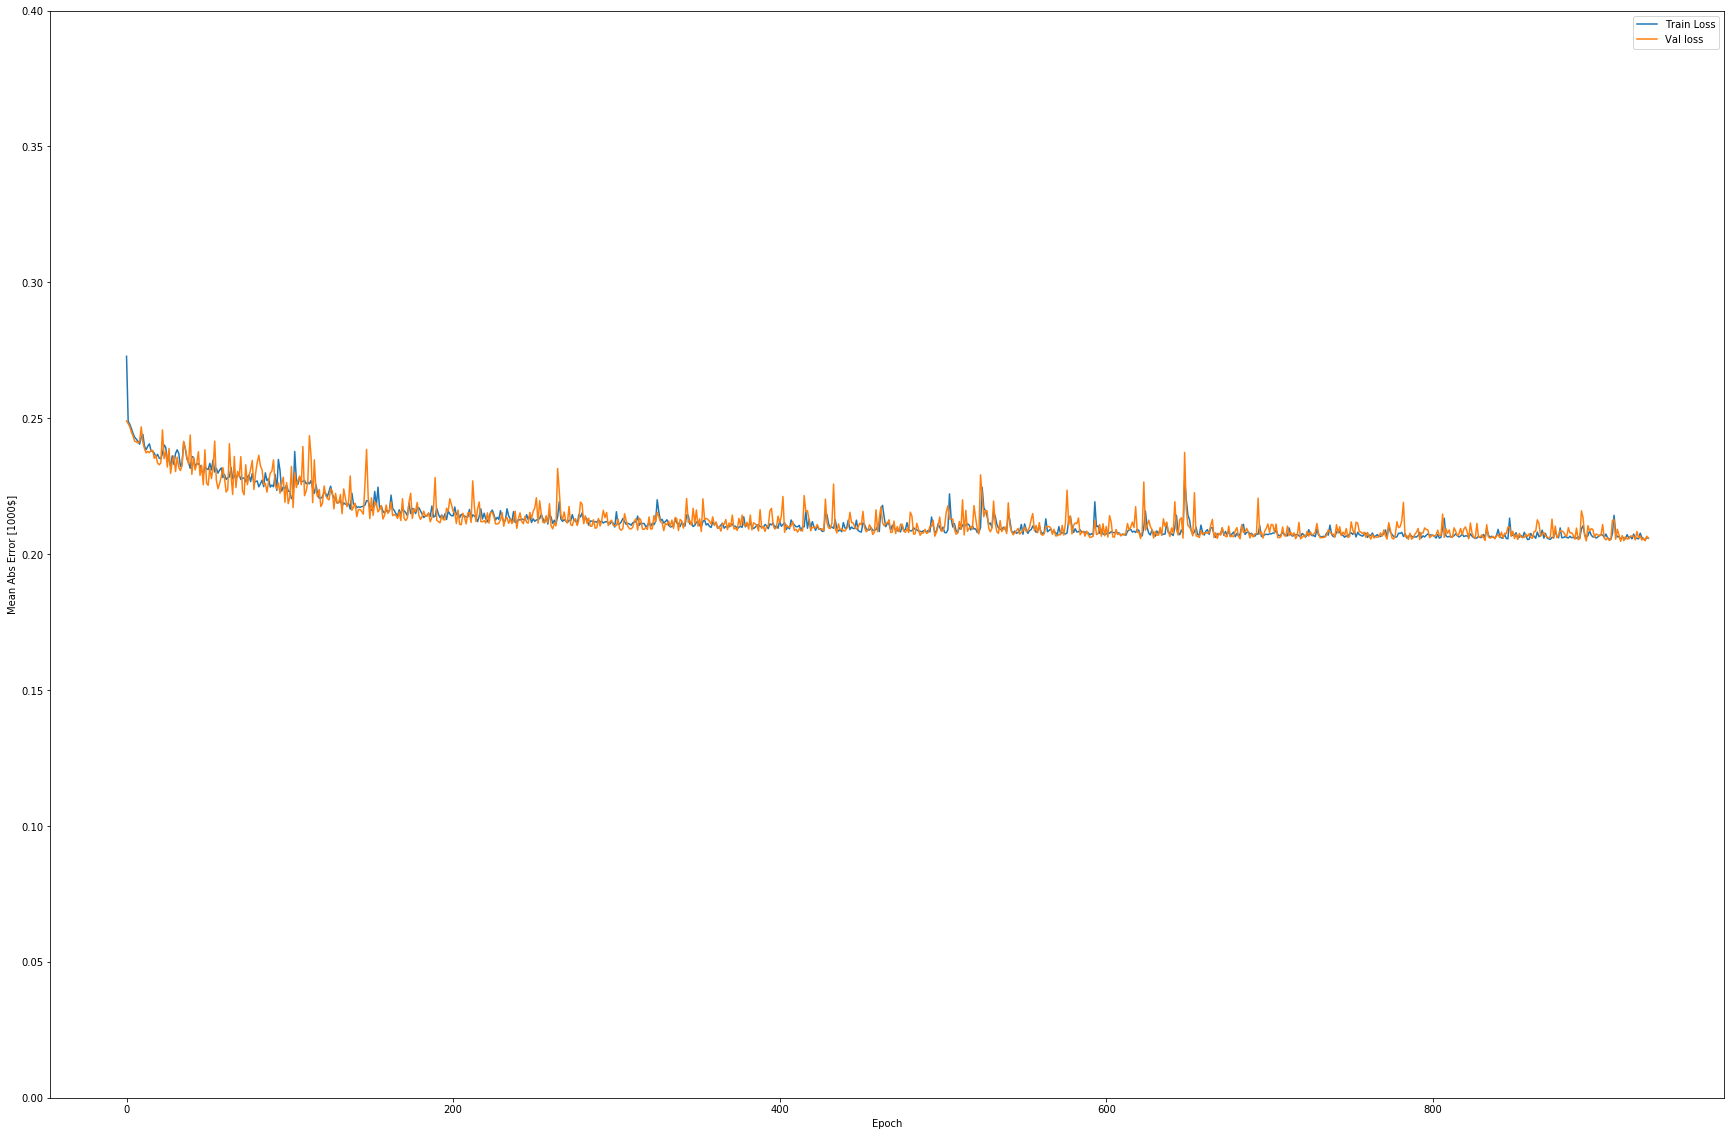

In [18]:
import matplotlib.pyplot as plt

#Plot the loss of the Training and the Validation sets, to monitor the evolution of the loss, and to spot a prospective over fitting

def plot_history(history):
  plt.figure(figsize = (30, 20))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,0.4])
  plt.savefig('loss_evolution.png')

plot_history(history)

In [19]:
#Prediction of the wanted parameter on the Test Data Set, with different metrics of prediction

predicted_test = pd.DataFrame(estimator.predict(X_test))

from scipy.stats import spearmanr, pearsonr

from sklearn.metrics import r2_score

pearson = pearsonr(Y_test, predicted_test)
r2 = r2_score(Y_test, predicted_test)

print("Global pearson correlation between predicted and effective parameter: ", pearson[0])


Global pearson correlation between predicted and effective parameter:  [0.50258805]
